# Exploration of T-SNE for Bias Inspection: HAM10k

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn import decomposition
from sklearn.manifold import TSNE

In [10]:
# Define constants
alpha = 0.6
style = 'o'
markersize = 40
fontscale = 1.6
color_palette = 'tab10'
kind = 'scatter'
rasterized_scatter = True
out_dpi = 300
out_format = 'png'

In [11]:
MODEL_FEATURES = {
    'resnet18': 512,
    'resnet34': 512,
    'resnet50': 2048,
    'resnet101': 2048,
}

In [12]:
def create_tsne(
        embeds_array: np.ndarray,
        model_df: pd.DataFrame
    ):
    
    # n -> number of samples
    # m -> number of features
    pca = decomposition.PCA(n_components=0.99, whiten=False)
    embeds_pca = pca.fit_transform(embeds_array)
    embeds_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeds_pca)

    model_df['t-SNE Dimension 1'] = embeds_tsne[:,0]
    model_df['t-SNE Dimension 2'] = embeds_tsne[:,1]

    # Replace numerical labels with categorical
    model_df['Labels'] = model_df['Labels'].replace({0: 'Benign', 1: 'Maglinant'})
    model_df['Sex'] = model_df['Sex'].replace({0: 'Male', 1: 'Female'})
    model_df['Age'] = model_df['Age'].replace({0: '<60', 1: '60+'})

In [13]:
def plot(
    label: str,
    df: pd.DataFrame,
    hue_order: list[str],
    model_id: str,
    save_dir: str
):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    ### PCA 1 + 2
    x_data = 't-SNE Dimension 1'
    y_data = 't-SNE Dimension 2'
    # Scatter with distributions
    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig = sns.jointplot(x=x_data, y=y_data, hue=label, kind=kind, alpha=alpha, marker=style, s=markersize, hue_order=hue_order, data=df, joint_kws=dict(rasterized=rasterized_scatter), marginal_kws={'common_norm': False})
    fig.ax_joint.legend(loc='upper right')
    plt.savefig(save_dir + 'tsne-1+2' + '-' + model_id + '-' + label + '.' + out_format, bbox_inches='tight', dpi=out_dpi)

    # Just distributions
    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig, ax = plt.subplots(figsize=(10,3))
    g = sns.kdeplot(x=x_data, hue=label, fill=True, hue_order=hue_order, data=df, ax=ax, common_norm=False)
    g.get_legend().set_title(None)
    g.spines[['right', 'top']].set_visible(False)
    plt.savefig(save_dir + 'tsne-1' + '-' + model_id + '-' + label + '-marginal.' + out_format, bbox_inches='tight', dpi=out_dpi)

    sns.set_theme(style="white", palette=color_palette, font_scale=fontscale)
    fig, ax = plt.subplots(figsize=(10,3))
    g = sns.kdeplot(x=y_data, hue=label, fill=True, hue_order=hue_order, data=df, ax=ax, common_norm=False)
    g.get_legend().set_title(None)
    g.spines[['right', 'top']].set_visible(False)
    plt.savefig(save_dir + 'tsne-2' + '-' + model_id + '-' + label + '-marginal.' + out_format, bbox_inches='tight', dpi=out_dpi)
  

    

In [14]:
def run_tsne_and_save_plots(
    model_id: str,
    model_name: str,
    model_dir: str,
    data_name: str, # chexpert_no_female, chexpert_no_old etc.
    sample: bool = False,
    teacher: bool = False,
):
    # Load Data
    embeds_data = pd.read_csv(f'{model_dir}/{model_id}/embeds.csv')
    model_df = pd.read_csv(f'{model_dir}/{model_id}/test_predictions.csv')
    embeds = np.array(embeds_data.iloc[:,0:MODEL_FEATURES[model_name]])

    if teacher:
        save_dir = f'teacher_{model_id}/'
    else:
        save_dir = f'{data_name}/{model_id}/'

    create_tsne(embeds, model_df)

    if sample:
        model_df = model_df.sample(frac=0.1)

    plot(
        label='Labels',
        df=model_df,
        hue_order=['Benign', 'Maglinant'],
        model_id=model_id,
        save_dir=save_dir,
    )

    plot(
        label='Sex',
        df=model_df,
        hue_order=['Male', 'Female'],
        model_id=model_id,
        save_dir=save_dir,
    )

    plot(
        label='Age',
        df=model_df,
        hue_order=['<60', '60+'],
        model_id=model_id,
        save_dir=save_dir,
    )

        

### Teachers

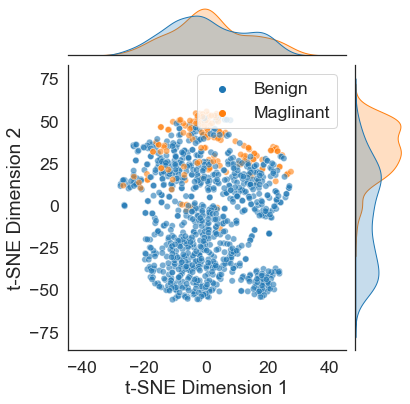

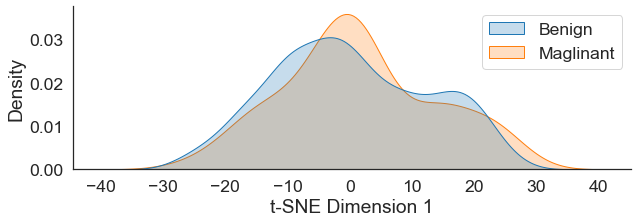

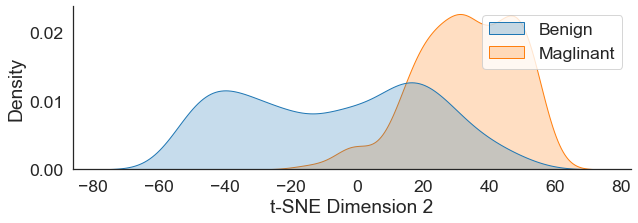

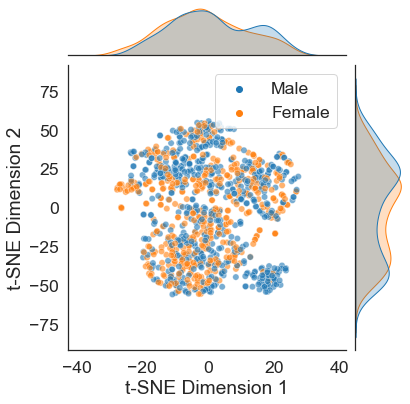

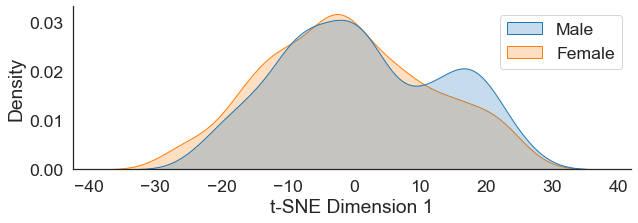

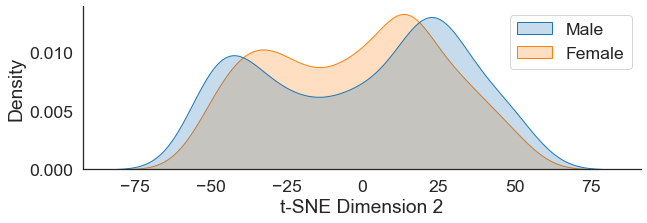

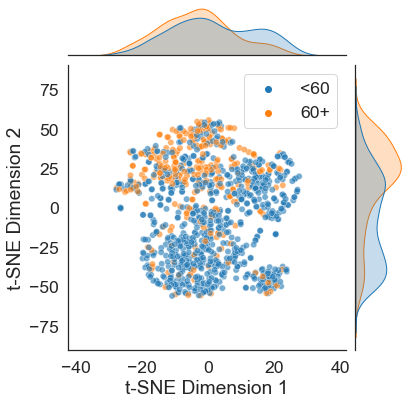

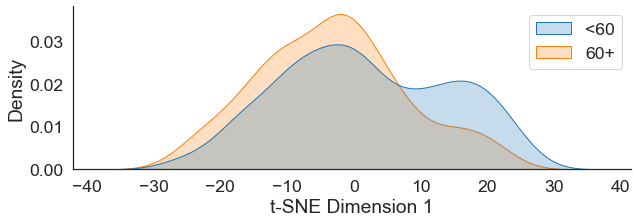

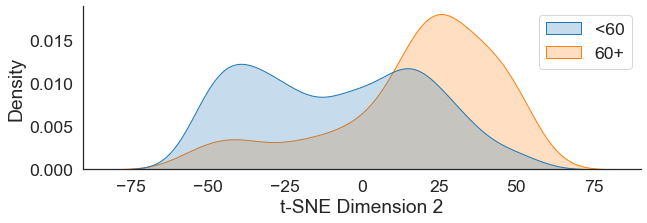

In [15]:
run_tsne_and_save_plots(
    model_id='r34-sam1-s46',
    model_name='resnet34',
    model_dir='../../results/ham10000/resnet/original',
    data_name='ham10000',
    sample=False,
    teacher=True,
)

### Students

#### No Female

##### ResNet18

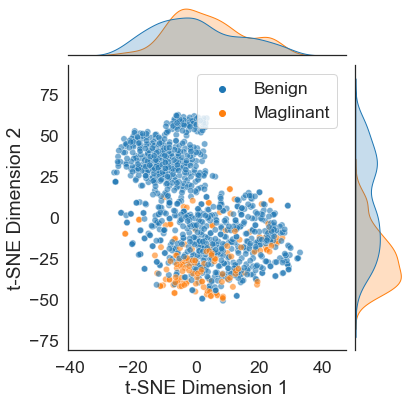

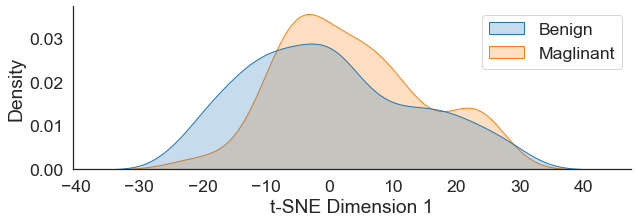

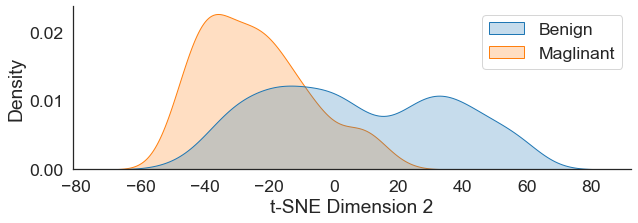

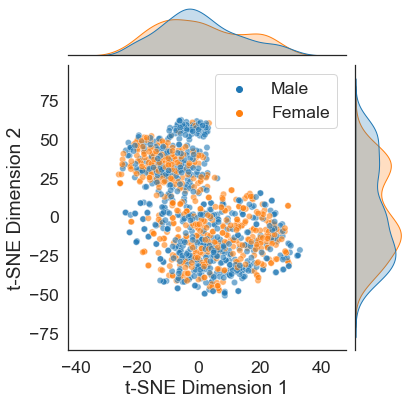

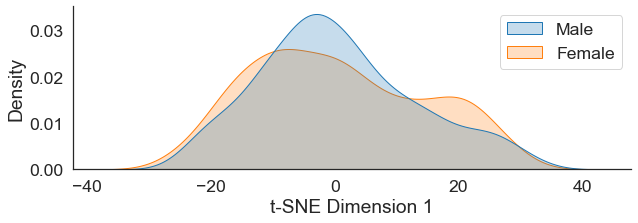

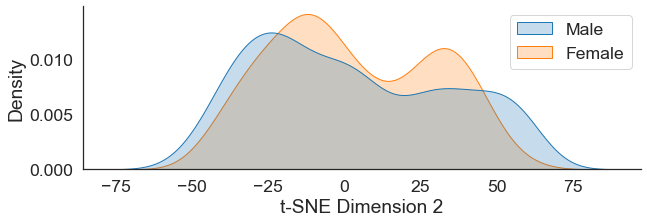

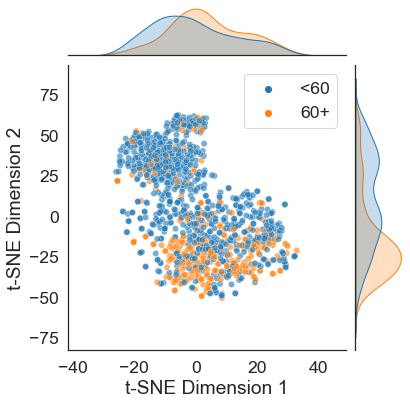

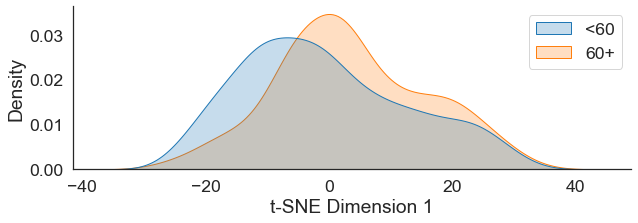

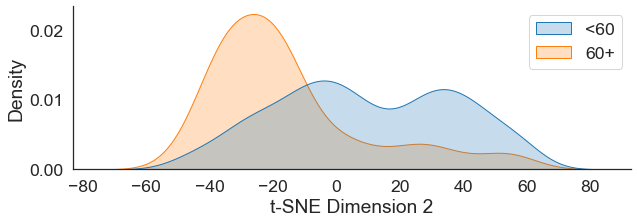

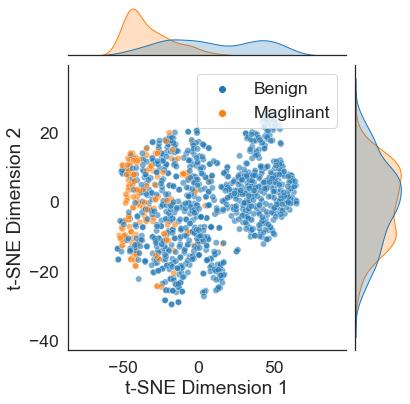

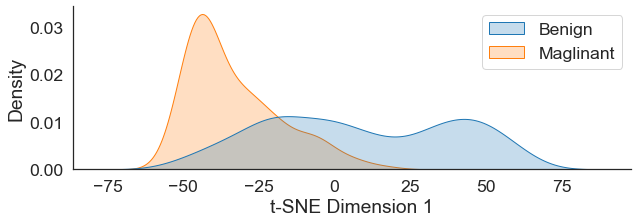

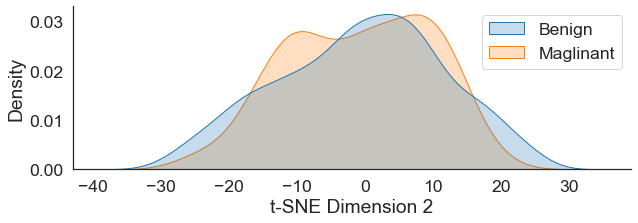

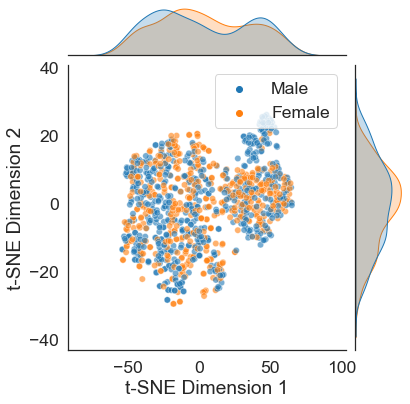

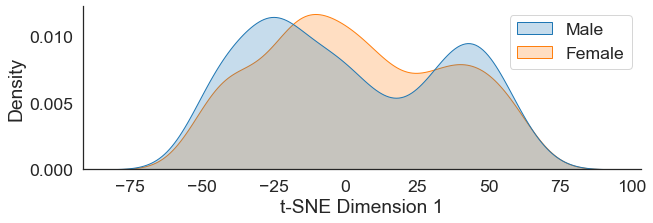

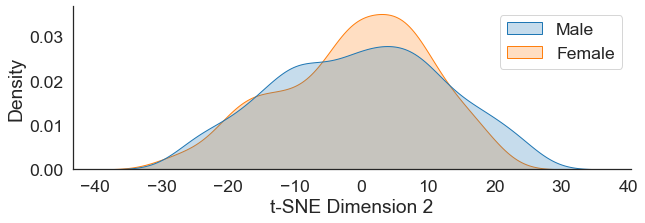

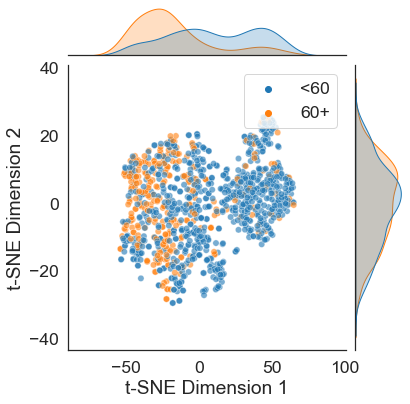

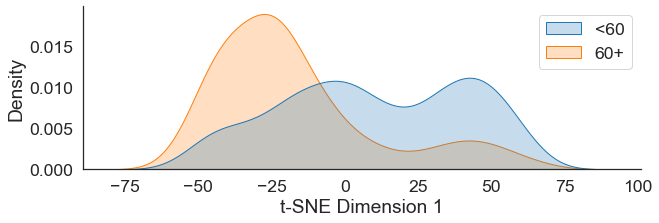

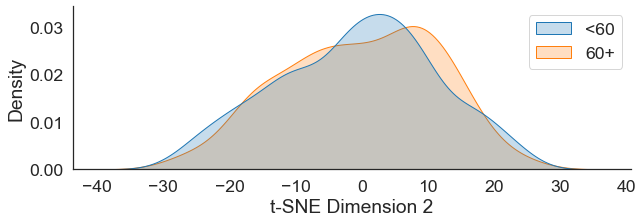

In [16]:
# Resnet18: Seed 46

# Without KD
run_tsne_and_save_plots(
    model_id='r18-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_female/resnet',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

# With KD
run_tsne_and_save_plots(
    model_id='r18-sam1-kd1-s46_r34-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_female/kd',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

##### ResNet34

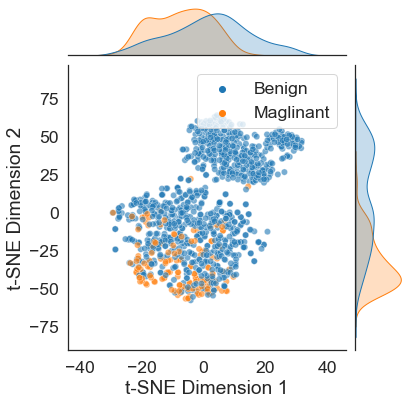

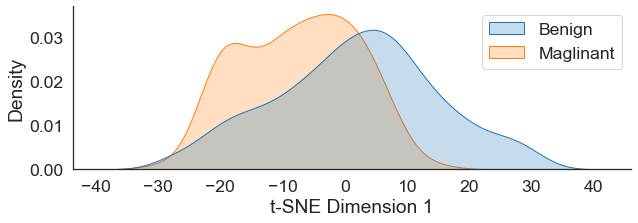

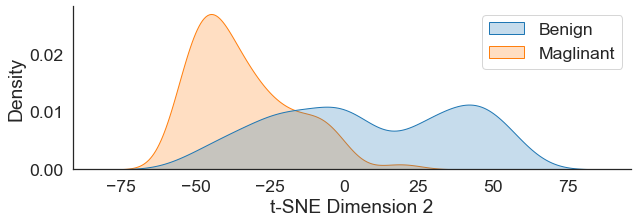

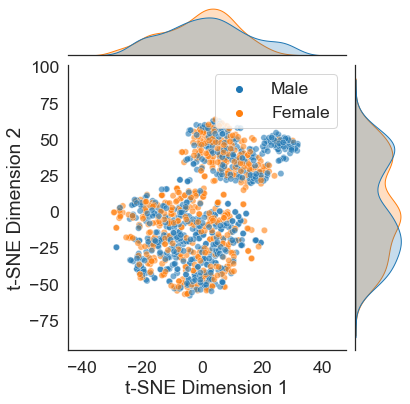

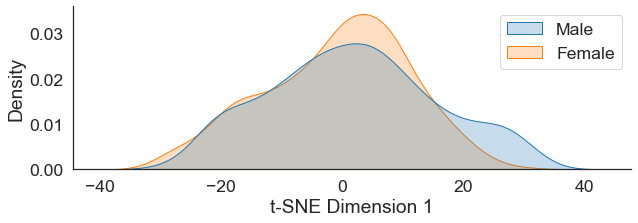

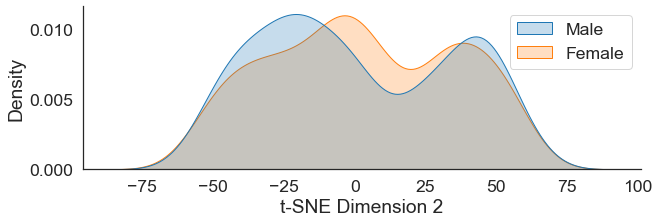

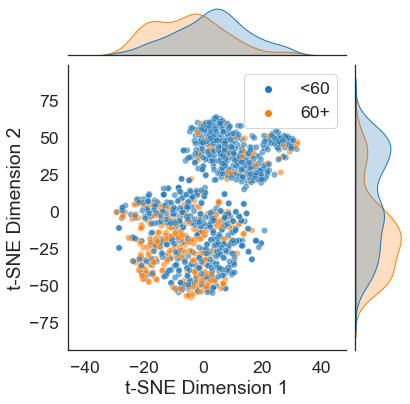

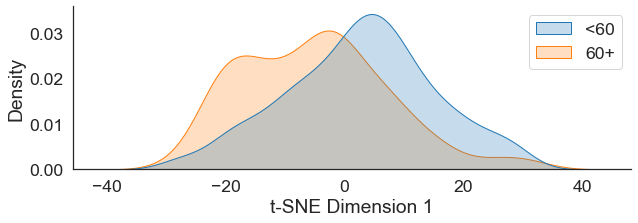

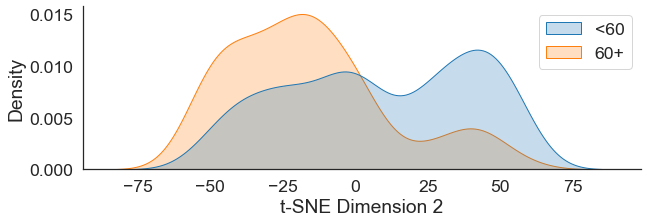

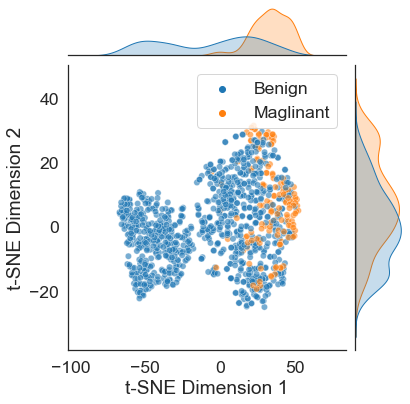

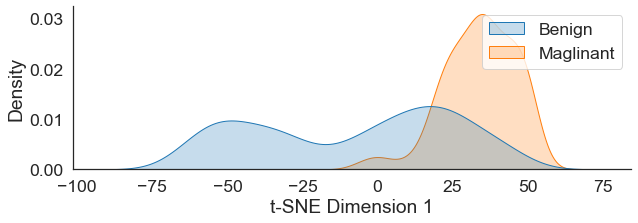

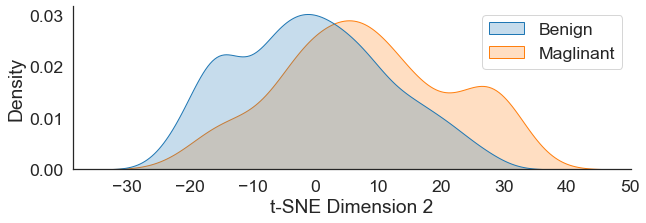

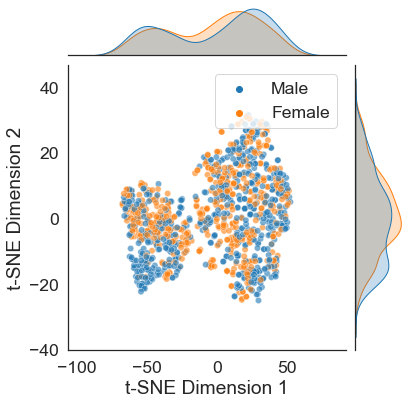

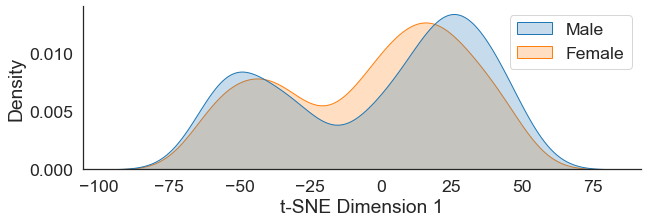

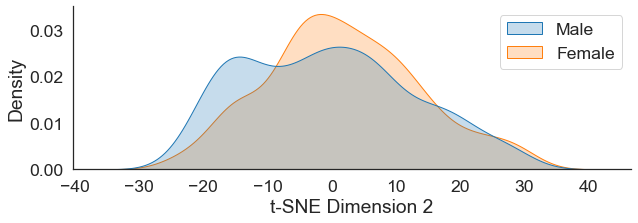

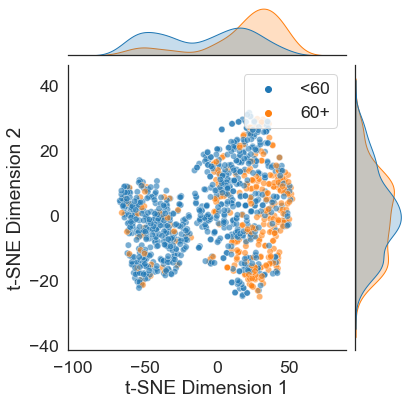

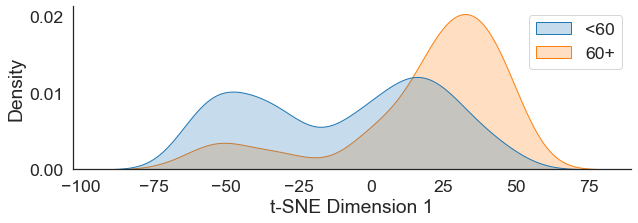

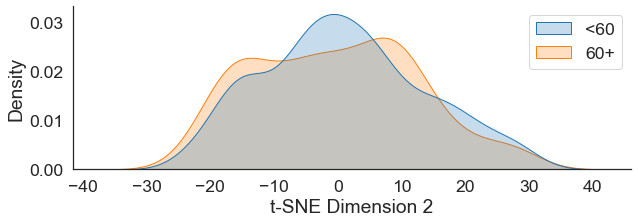

In [17]:
# Resnet34: Seed 42

# Without KD
run_tsne_and_save_plots(
    model_id='r34-sam1-s42',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_female/resnet',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

# With KD
run_tsne_and_save_plots(
    model_id='r34-sam1-kd1-s42_r34-sam1-s46',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_female/kd',
    data_name='ham10000_no_female',
    sample=False,
    teacher=False,
)

#### No Old

##### ResNet18

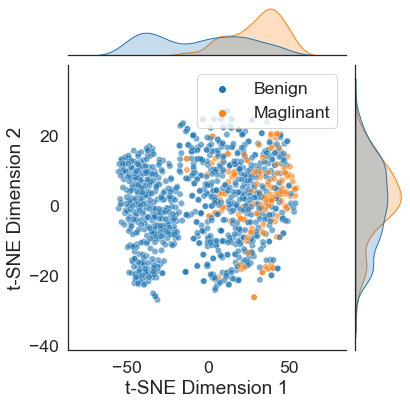

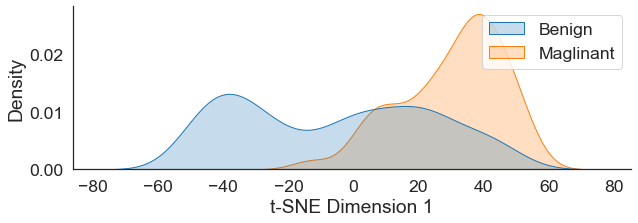

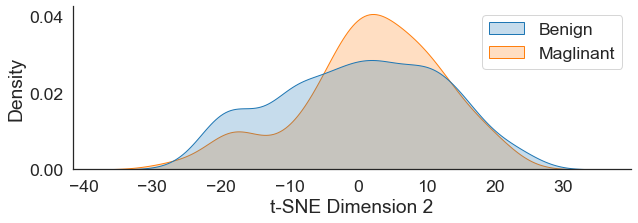

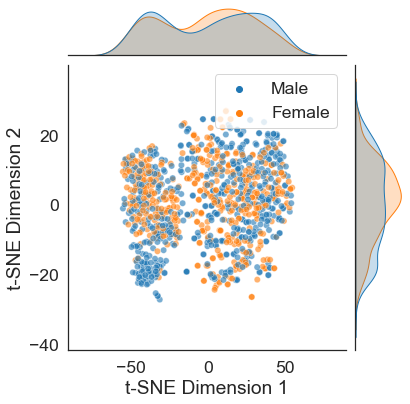

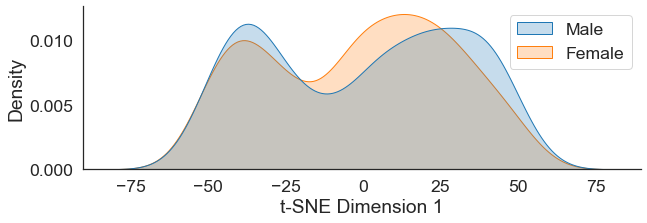

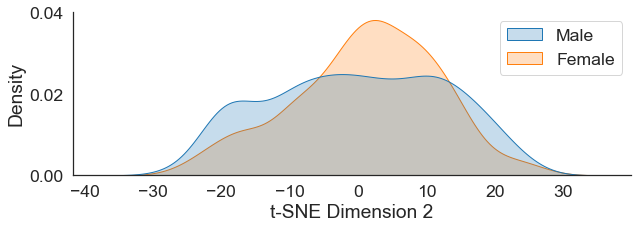

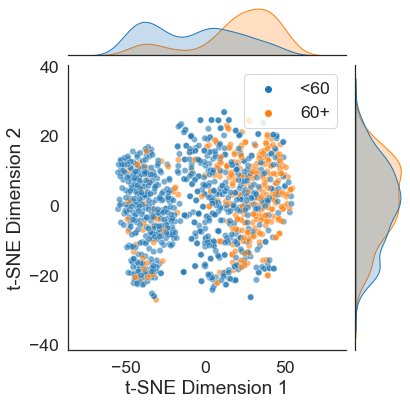

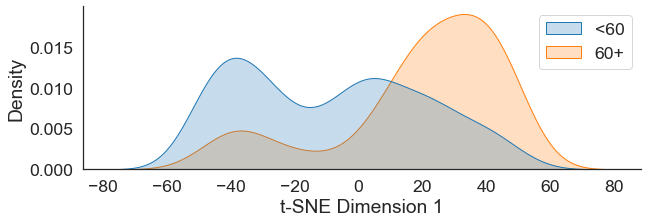

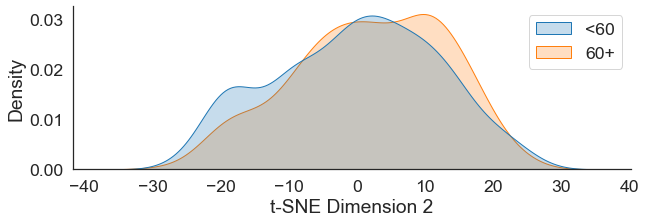

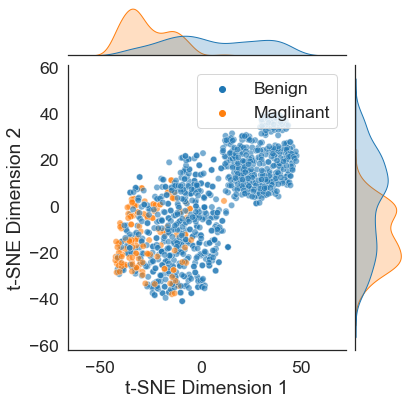

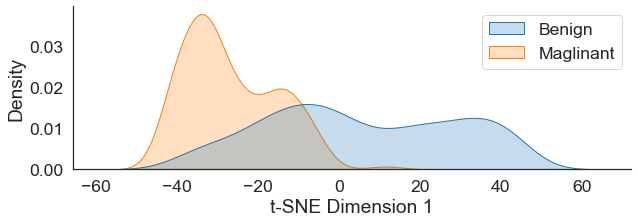

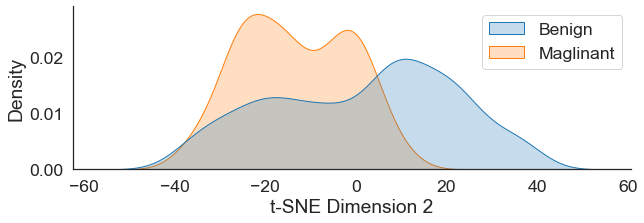

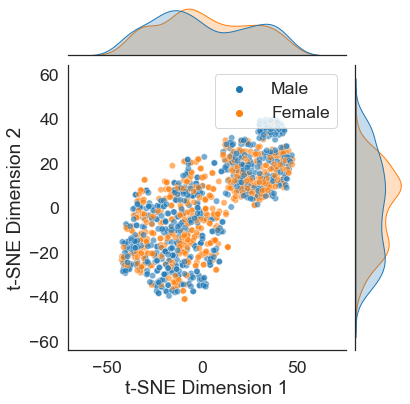

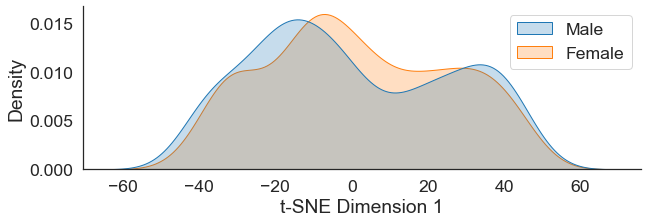

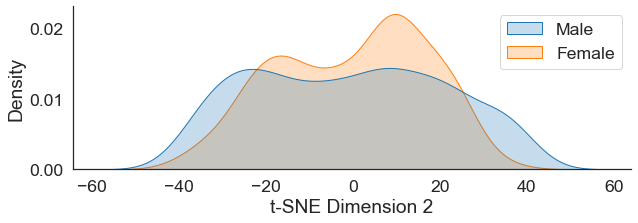

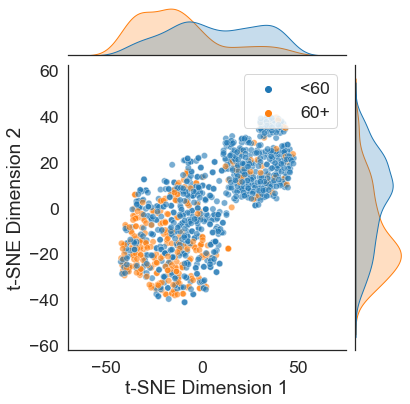

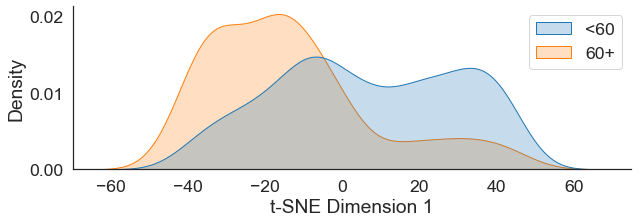

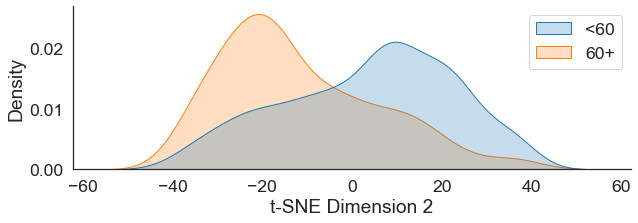

In [18]:
# Resnet18: Seed 46

# Without KD
run_tsne_and_save_plots(
    model_id='r18-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_old/resnet',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)

# With KD
run_tsne_and_save_plots(
    model_id='r18-sam1-kd1-s46_r34-sam1-s46',
    model_name='resnet18',
    model_dir='../../results/ham10000_no_old/kd',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)

##### ResNet34

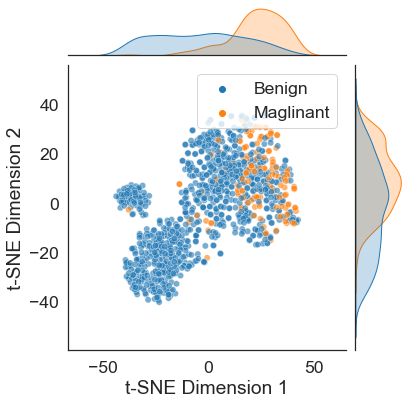

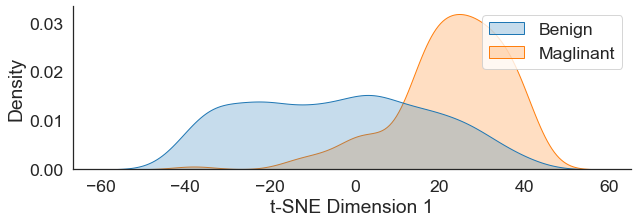

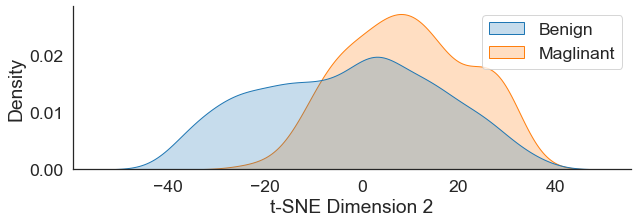

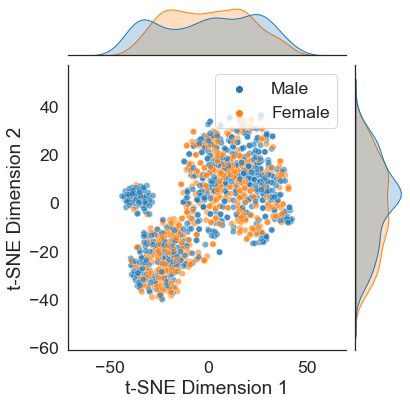

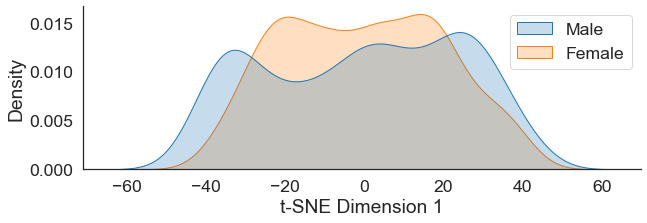

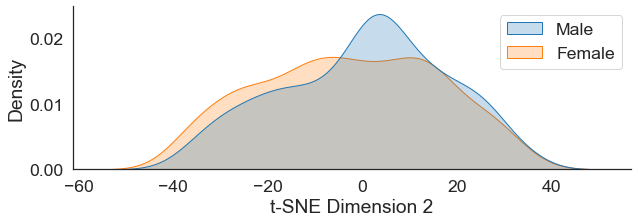

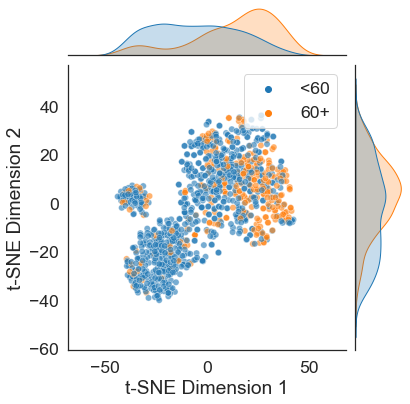

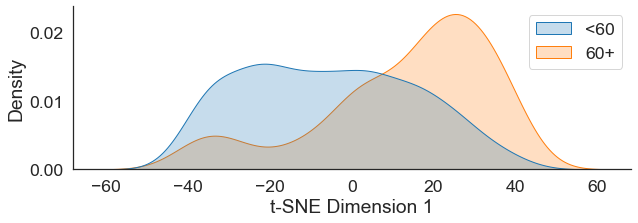

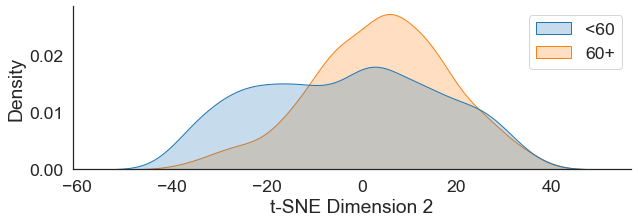

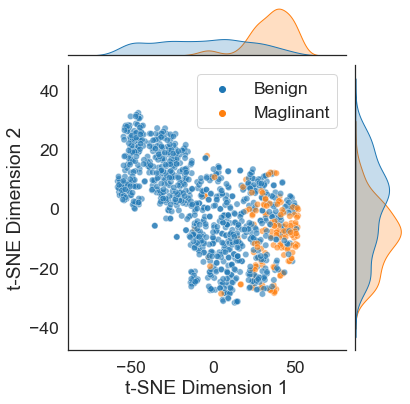

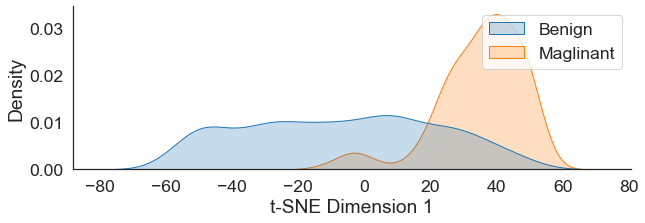

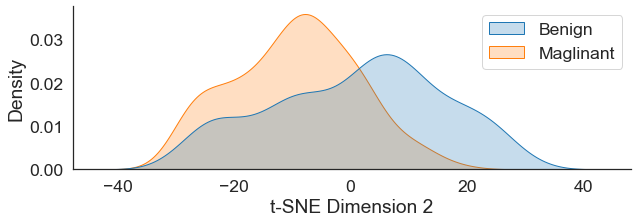

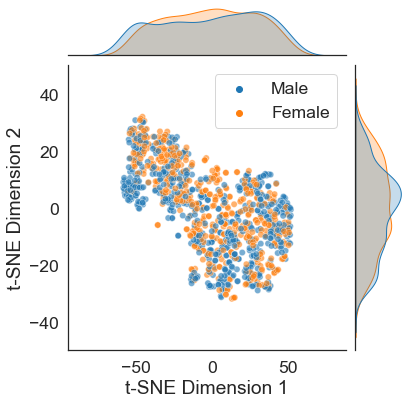

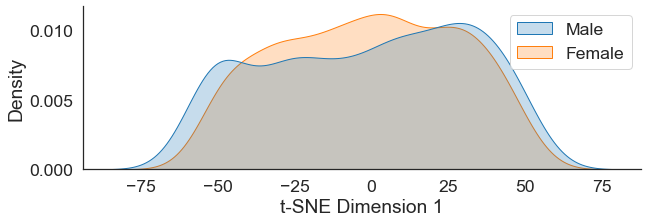

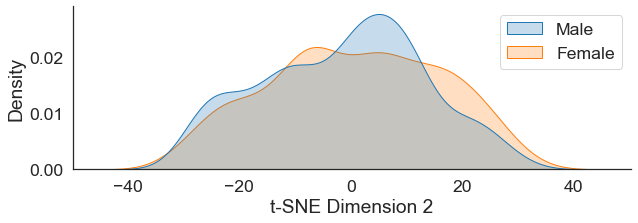

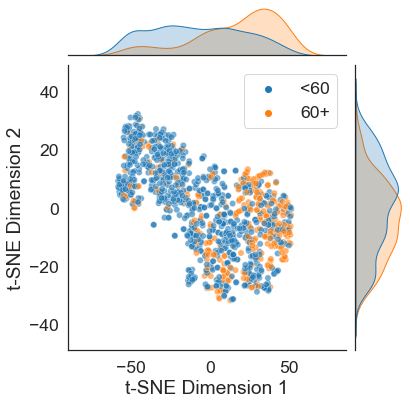

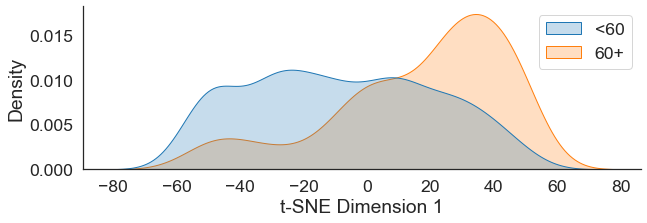

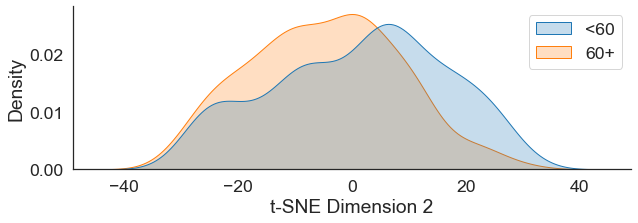

In [19]:
# Resnet18: Seed 46

# Without KD
run_tsne_and_save_plots(
    model_id='r34-sam1-s42',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_old/resnet',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)

# With KD
run_tsne_and_save_plots(
    model_id='r34-sam1-kd1-s42_r34-sam1-s46',
    model_name='resnet34',
    model_dir='../../results/ham10000_no_old/kd',
    data_name='ham10000_no_old',
    sample=False,
    teacher=False,
)